In [2]:
import psycopg2
import pandas as pd 
# from sqlalchemy.types import Integer, Text, String, DateTime
import sqlalchemy as s
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgres+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = s.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [3]:
test_query = f"""
SELECT repo_name from repo where repo_id = '26983';
   """
test = pd.read_sql_query(test_query, con=engine)
repo_name = test.repo_name[0]
print(repo_name)

postfacto


In [4]:
repo_list = pd.DataFrame()
repo_list_query = f"""
SELECT repo_id, repo_name, repo_path from repo
WHERE repo_name = 'concourse' OR repo_name = 'postfacto' or repo_name = 'clarity' or repo_name = 'gpdb' or
      repo_name = 'kpack';
    """
repo_list = pd.read_sql_query(repo_list_query, con=engine)
print(repo_list)

   repo_id  repo_name                              repo_path
0    26235  concourse               github.com/pcfdev-forks/
1    28051  concourse                  github.com/concourse/
2    27913    clarity                     github.com/vmware/
3    26983  postfacto                    github.com/pivotal/
4    27169       gpdb                github.com/pivotal-gss/
5    25857       gpdb               github.com/greenplum-db/
6    26600       gpdb  github.com/Pivotal-Field-Engineering/
7    27043      kpack                    github.com/pivotal/


In [48]:
## List of repository IDs for the report
#repo_dict = {25760, 25663} #spring-boot & spring-framework
#repo_dict = {28051} # concourse
#repo_dict = {26983} #postfacto
repo_dict = {25663}

In [49]:
#from datetime import date
import datetime 

current = datetime.date.today()
today = "'" + str(current) + "'"
print(today)

start = current - datetime.timedelta(days=365)
year_ago = "'" + str(start) + "'"
print(year_ago)

'2020-03-10'
'2019-03-11'


Empty DataFrame
Columns: []
Index: []
25663
first time


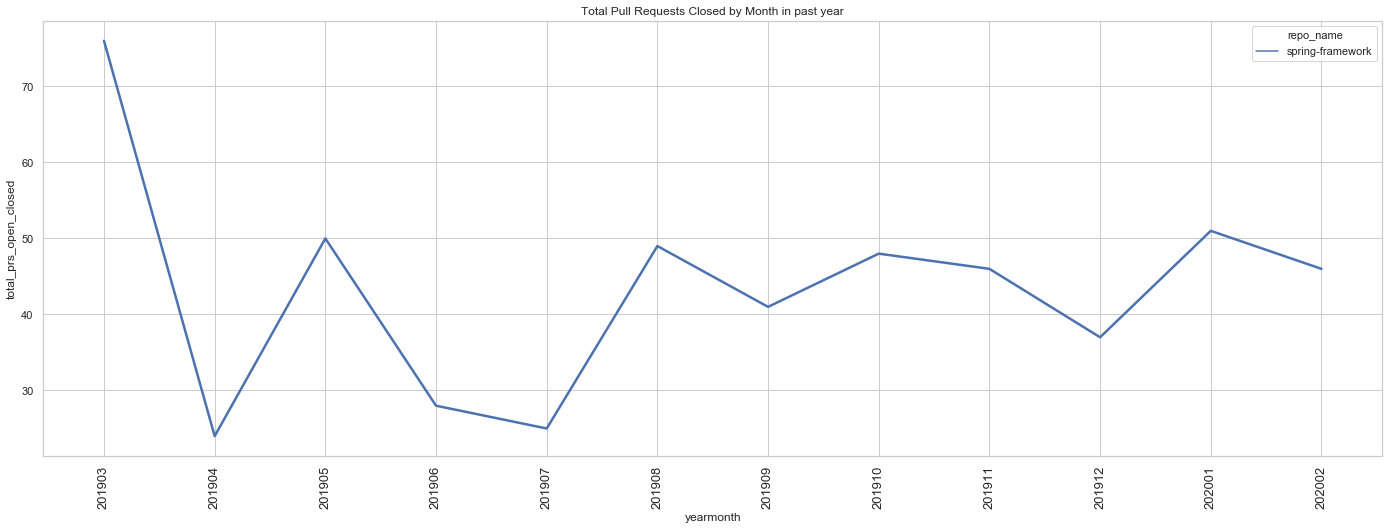

In [50]:
# Monthly PRs closed
pr_monthDF = pd.DataFrame()
print(pr_monthDF)
for value in repo_dict: 
    print(value)
#    sql_DFa = pd.read_sql
    pr_monthquery = f"""
                    SELECT
                        * 
                    FROM
                        (
                        SELECT
                            date_part( 'year', month :: DATE ) AS YEAR,
                            date_part( 'month', month :: DATE ) AS month 
                        FROM
                            ( SELECT * FROM ( SELECT month :: DATE FROM generate_series ( TIMESTAMP {year_ago}, TIMESTAMP {today}, INTERVAL '1 month' ) month ) d ) x 
                        ) y
                        LEFT OUTER JOIN (
                        SELECT
                            repo_id,
                            repo_name,
                            repo_group,
                            date_part( 'year', pr_created_at :: DATE ) AS YEAR,
                            date_part( 'month', pr_created_at :: DATE ) AS month,
                            COUNT ( pr_src_id ) AS total_prs_open_closed 
                        FROM
                            (
                            SELECT
                                repo.repo_id AS repo_id,
                                repo.repo_name AS repo_name,
                                repo_groups.rg_name AS repo_group,
                                pull_requests.pr_created_at AS pr_created_at,
                                pull_requests.pr_closed_at AS pr_closed_at,
                                pull_requests.pr_src_id AS pr_src_id
                            FROM
                                repo,
                                repo_groups,
                                pull_requests 
                            WHERE
                                repo.repo_group_id = repo_groups.repo_group_id 
                                AND repo.repo_id = pull_requests.repo_id 
                                AND repo.repo_id = {value} 
                                AND pull_requests.pr_src_state = 'closed'  
                            ) L 
                        GROUP BY
                            L.repo_id,
                            L.repo_name,
                            L.repo_group,
                            YEAR,
                            month 
                        ORDER BY
                            repo_id,
                            YEAR,
                            month 
                        ) T USING ( month, YEAR ) 
                    ORDER BY
                        YEAR,
                        month;

        """
    pr_monthDFa = pd.read_sql_query(pr_monthquery, con=engine)
    repo_id = value
#    pr_monthDFa[['wk_avg_hours_to_close', 'wk_avg_days_to_close', 'total_prs_open_closed' ]] = pr_monthDFa[['wk_avg_hours_to_close', 'wk_avg_days_to_close', 'total_prs_open_closed' ]].fillna(value=0)

    pr_monthDFa[['repo_id']] = pr_monthDFa[['repo_id']].fillna(value=repo_id)
    
    # Hack to fill in repo_name where there are nan's
    get_repo_name_query = f"""
        SELECT repo_name from repo where repo_id = {value};
           """
    get_repo_name = pd.read_sql_query(get_repo_name_query, con=engine)
    repo_name = get_repo_name.repo_name[0]
    pr_monthDFa[['repo_name']] = pr_monthDFa[['repo_name']].fillna(value=repo_name)
    
    if not pr_monthDF.empty: 
#        print(sql_DFa)
        pr_monthDF = pd.concat([pr_monthDF, pr_monthDFa]) 
#        print(sql_DF)
    else: 
        print('first time')
        pr_monthDF = pr_monthDFa
#        print(sql_DF)
        pr_monthDF.set_index('repo_id', 'year', 'month')


pr_monthDF.set_index('repo_id', 'year', 'month')

pr_monthDF[['total_prs_open_closed']] = pr_monthDF[['total_prs_open_closed']].fillna(0)

import matplotlib.pyplot as plt
pr_monthDF['year'] = pr_monthDF['year'].map(int)
pr_monthDF['month'] = pr_monthDF['month'].map(int)
pr_monthDF['repo_id'] = pr_monthDF['repo_id'].map(int)
pr_monthDF['month'] = pr_monthDF['month'].map(lambda x: '{0:0>2}'.format(x))
pr_monthDF['yearmonth'] = pr_monthDF['year'].map(str)+pr_monthDF['month'].map(str)
#sql_DF['yearweek'] = sql_DF['yearweek'].map(int)
pr_monthDF['month'] = pr_monthDF['month'].map(int)
pr_monthDF.set_index('repo_id', 'yearmonth')
#print(sql_DF)
#sql_DF.dtypes

sns.set_style('ticks')
#sns.palplot(sns.color_palette('husl', 8))
#sns.set_palette('husl')
sns.set(style="whitegrid")


#Total PRS open and closed by month
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(24, 8)
plottermonth = sns.lineplot(x='yearmonth', y='total_prs_open_closed', style='repo_name', data=pr_monthDF, sort=False, legend='full', linewidth=2.5, hue='repo_name').set_title("Total Pull Requests Closed by Month in past year")   
#ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)
plottermonthlabels = ax.set_xticklabels(pr_monthDF['yearmonth'], rotation=90, fontsize=13)
fig.savefig('images/prs-monthly-total-open-closed.png')


#Average Days Open by Month
#fig, ax = plt.subplots()
# the size of A4 paper
#fig.set_size_inches(24, 24)
#plottermonth = sns.lineplot(x='yearmonth', y='wk_avg_days_to_close', style='repo_name', data=pr_monthDF, sort=False, legend='full', linewidth=2.5, hue='repo_name').set_title("Average Closed PR Time Open by Month in past year")   
#ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)
#plotterlabels = ax.set_xticklabels(pr_monthDF['yearmonth'], rotation=90, fontsize=8)
#fig.savefig('images/prs-average-open-time-month.png')


In [51]:
pr_slopeDF = pd.DataFrame()
pr_slopeDF['yearmonth'] = pr_monthDF['yearmonth']
pr_slopeDF['closed_slope'] = pr_monthDF['total_prs_open_closed'] - pr_monthDF['total_prs_open_closed'].shift()
pr_slopeDF['closed_total'] = pr_monthDF['total_prs_open_closed']
print(pr_slopeDF)

   yearmonth  closed_slope  closed_total
0     201903           NaN            76
1     201904         -52.0            24
2     201905          26.0            50
3     201906         -22.0            28
4     201907          -3.0            25
5     201908          24.0            49
6     201909          -8.0            41
7     201910           7.0            48
8     201911          -2.0            46
9     201912          -9.0            37
10    202001          14.0            51
11    202002          -5.0            46


Empty DataFrame
Columns: []
Index: []
25663
first time


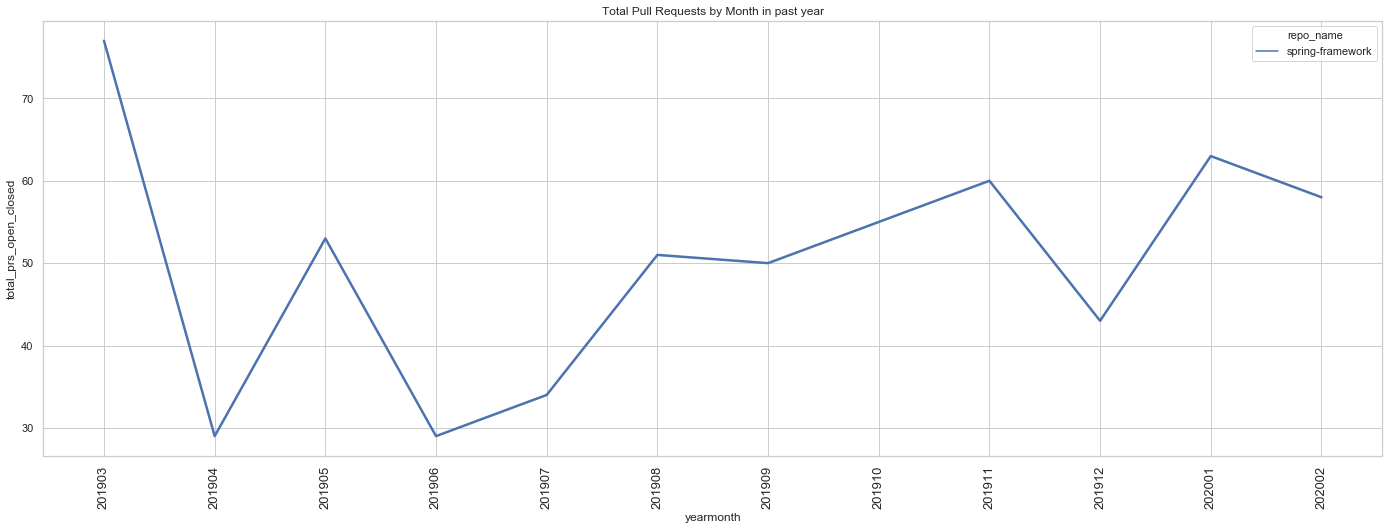

In [52]:
# Monthly PRs ALL - removed where pull_requests.pr_src_state = 'closed' 
pr_monthDF = pd.DataFrame()
print(pr_monthDF)
for value in repo_dict: 
    print(value)
#    sql_DFa = pd.read_sql
    pr_monthquery = f"""
                    SELECT
                        * 
                    FROM
                        (
                        SELECT
                            date_part( 'year', month :: DATE ) AS YEAR,
                            date_part( 'month', month :: DATE ) AS month 
                        FROM
                            ( SELECT * FROM ( SELECT month :: DATE FROM generate_series ( TIMESTAMP {year_ago}, TIMESTAMP {today}, INTERVAL '1 month' ) month ) d ) x 
                        ) y
                        LEFT OUTER JOIN (
                        SELECT
                            repo_id,
                            repo_name,
                            repo_group,
                            date_part( 'year', pr_created_at :: DATE ) AS YEAR,
                            date_part( 'month', pr_created_at :: DATE ) AS month,
                            COUNT ( pr_src_id ) AS total_prs_open_closed 
                        FROM
                            (
                            SELECT
                                repo.repo_id AS repo_id,
                                repo.repo_name AS repo_name,
                                repo_groups.rg_name AS repo_group,
                                pull_requests.pr_created_at AS pr_created_at,
                                pull_requests.pr_closed_at AS pr_closed_at,
                                pull_requests.pr_src_id AS pr_src_id
                            FROM
                                repo,
                                repo_groups,
                                pull_requests 
                            WHERE
                                repo.repo_group_id = repo_groups.repo_group_id 
                                AND repo.repo_id = pull_requests.repo_id 
                                AND repo.repo_id = {value} 
                            ) L 
                        GROUP BY
                            L.repo_id,
                            L.repo_name,
                            L.repo_group,
                            YEAR,
                            month 
                        ORDER BY
                            repo_id,
                            YEAR,
                            month 
                        ) T USING ( month, YEAR ) 
                    ORDER BY
                        YEAR,
                        month;

        """
    pr_monthDFa = pd.read_sql_query(pr_monthquery, con=engine)
    repo_id = value
#    pr_monthDFa[['wk_avg_hours_to_close', 'wk_avg_days_to_close', 'total_prs_open_closed' ]] = pr_monthDFa[['wk_avg_hours_to_close', 'wk_avg_days_to_close', 'total_prs_open_closed' ]].fillna(value=0)
    pr_monthDFa[['repo_id']] = pr_monthDFa[['repo_id']].fillna(value=repo_id)
    
    # Hack to fill in repo_name where there are nan's
    get_repo_name_query = f"""
        SELECT repo_name from repo where repo_id = {value};
           """
    get_repo_name = pd.read_sql_query(get_repo_name_query, con=engine)
    repo_name = get_repo_name.repo_name[0]
    pr_monthDFa[['repo_name']] = pr_monthDFa[['repo_name']].fillna(value=repo_name)
    
    if not pr_monthDF.empty: 
#        print(sql_DFa)
        pr_monthDF = pd.concat([pr_monthDF, pr_monthDFa]) 
#        print(sql_DF)
    else: 
        print('first time')
        pr_monthDF = pr_monthDFa
#        print(sql_DF)
        pr_monthDF.set_index('repo_id', 'year', 'month')


pr_monthDF.set_index('repo_id', 'year', 'month')

pr_monthDF[['total_prs_open_closed']] = pr_monthDF[['total_prs_open_closed']].fillna(0)

import matplotlib.pyplot as plt
pr_monthDF['year'] = pr_monthDF['year'].map(int)
pr_monthDF['month'] = pr_monthDF['month'].map(int)
pr_monthDF['repo_id'] = pr_monthDF['repo_id'].map(int)
pr_monthDF['month'] = pr_monthDF['month'].map(lambda x: '{0:0>2}'.format(x))
pr_monthDF['yearmonth'] = pr_monthDF['year'].map(str)+pr_monthDF['month'].map(str)
#sql_DF['yearweek'] = sql_DF['yearweek'].map(int)
pr_monthDF['month'] = pr_monthDF['month'].map(int)
pr_monthDF.set_index('repo_id', 'yearmonth')
#print(sql_DF)
#sql_DF.dtypes

sns.set_style('ticks')
#sns.palplot(sns.color_palette('husl', 8))
#sns.set_palette('husl')
sns.set(style="whitegrid")


#Total PRS open and closed by month
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(24, 8)
plottermonth = sns.lineplot(x='yearmonth', y='total_prs_open_closed', style='repo_name', data=pr_monthDF, sort=False, legend='full', linewidth=2.5, hue='repo_name').set_title("Total Pull Requests by Month in past year")   
#ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)
plottermonthlabels = ax.set_xticklabels(pr_monthDF['yearmonth'], rotation=90, fontsize=13)
fig.savefig('images/prs-monthly-total-open-closed.png')


#Average Days Open by Month
#fig, ax = plt.subplots()
# the size of A4 paper
#fig.set_size_inches(24, 24)
#plottermonth = sns.lineplot(x='yearmonth', y='wk_avg_days_to_close', style='repo_name', data=pr_monthDF, sort=False, legend='full', linewidth=2.5, hue='repo_name').set_title("Average Closed PR Time Open by Month in past year")   
#ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)
#plotterlabels = ax.set_xticklabels(pr_monthDF['yearmonth'], rotation=90, fontsize=8)
#fig.savefig('images/prs-average-open-time-month.png')


In [53]:
print()
pr_slopeDF['all_slope'] = pr_monthDF['total_prs_open_closed'] - pr_monthDF['total_prs_open_closed'].shift()
pr_slopeDF['all_total'] = pr_monthDF['total_prs_open_closed']
pr_slopeDF['diff'] = pr_slopeDF['all_total'] - pr_slopeDF['closed_total']
print(pr_slopeDF)


   yearmonth  closed_slope  closed_total  all_slope  all_total  diff
0     201903           NaN            76        NaN         77     1
1     201904         -52.0            24      -48.0         29     5
2     201905          26.0            50       24.0         53     3
3     201906         -22.0            28      -24.0         29     1
4     201907          -3.0            25        5.0         34     9
5     201908          24.0            49       17.0         51     2
6     201909          -8.0            41       -1.0         50     9
7     201910           7.0            48        5.0         55     7
8     201911          -2.0            46        5.0         60    14
9     201912          -9.0            37      -17.0         43     6
10    202001          14.0            51       20.0         63    12
11    202002          -5.0            46       -5.0         58    12


In [54]:
print((pr_slopeDF['all_total'] - pr_slopeDF['closed_total']).mean())
print((pr_slopeDF['all_total'] - pr_slopeDF['closed_total']).median())
print((pr_slopeDF['all_total'] - pr_slopeDF['closed_total']).std())
print((pr_slopeDF['all_total'] - pr_slopeDF['closed_total']).describe())
print((pr_slopeDF['all_total'] - pr_slopeDF['closed_total']).quantile(.65))

6.75
6.5
4.5151260930746595
count    12.000000
mean      6.750000
std       4.515126
min       1.000000
25%       2.750000
50%       6.500000
75%       9.750000
max      14.000000
dtype: float64
9.0


In [55]:
# Months at risk
print(pr_slopeDF.loc[pr_slopeDF['diff'] > (pr_slopeDF['all_total'] - pr_slopeDF['closed_total']).quantile(.65), 'yearmonth'])

8     201911
10    202001
11    202002
Name: yearmonth, dtype: object


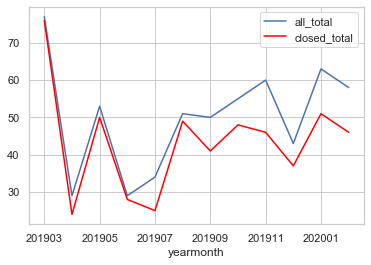

In [58]:
ax = plt.gca()

pr_slopeDF.plot(kind='line',x='yearmonth',y='all_total', ax=ax)
pr_slopeDF.plot(kind='line',x='yearmonth',y='closed_total', color='red', ax=ax)

plt.show()

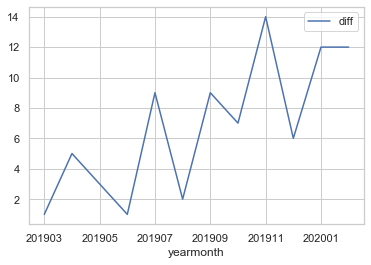

In [59]:
ax = plt.gca()

pr_slopeDF.plot(kind='line',x='yearmonth',y='diff', ax=ax)

plt.show()